In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import json

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("/content/Transactions - Transactions.csv")

In [3]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# EDA: Summary Statistics
print("Customers Summary:\n", customers.describe(include='all'))
print("Products Summary:\n", products.describe(include='all'))
print("Transactions Summary:\n", transactions.describe(include='all'))

Customers Summary:
        CustomerID      CustomerName         Region           SignupDate
count         200               200            200                  200
unique        200               200              4                  NaN
top         C0001  Lawrence Carroll  South America                  NaN
freq            1                 1             59                  NaN
mean          NaN               NaN            NaN  2023-07-19 08:31:12
min           NaN               NaN            NaN  2022-01-22 00:00:00
25%           NaN               NaN            NaN  2022-09-26 12:00:00
50%           NaN               NaN            NaN  2023-08-31 12:00:00
75%           NaN               NaN            NaN  2024-04-12 12:00:00
max           NaN               NaN            NaN  2024-12-28 00:00:00
Products Summary:
        ProductID            ProductName Category       Price
count        100                    100      100  100.000000
unique       100                     66        

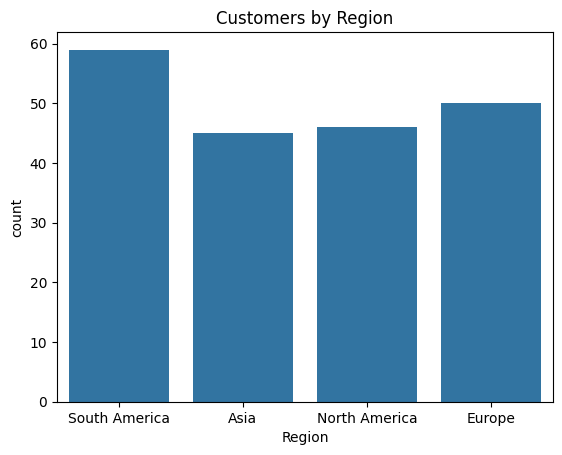

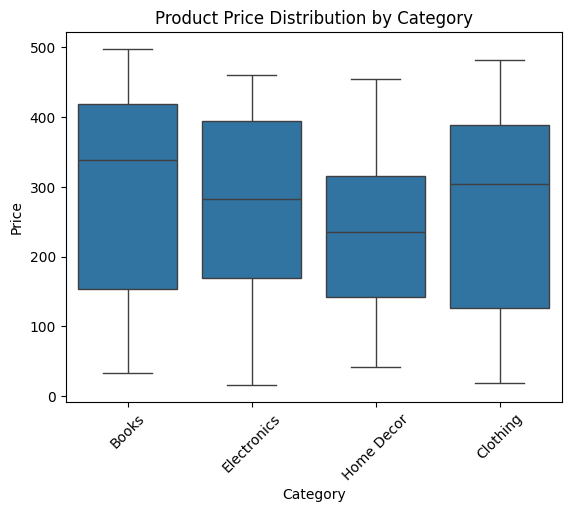

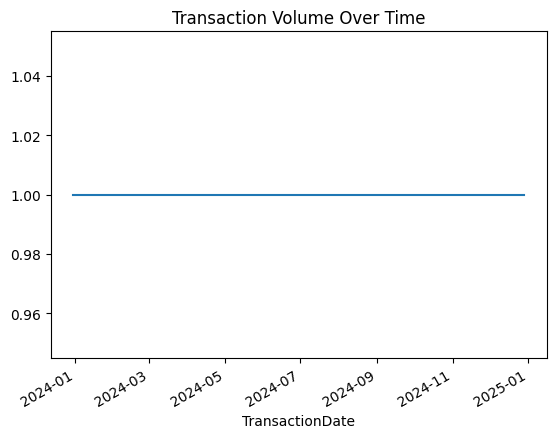

In [4]:
# EDA: Visualizations
sns.countplot(data=customers, x='Region')
plt.title('Customers by Region')
plt.show()

sns.boxplot(data=products, x='Category', y='Price')
plt.title('Product Price Distribution by Category')
plt.xticks(rotation=45)
plt.show()

transactions.groupby('TransactionDate').size().plot(title='Transaction Volume Over Time')
plt.show()

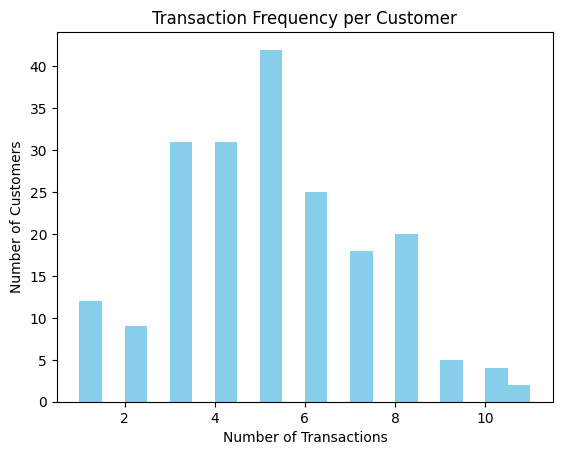

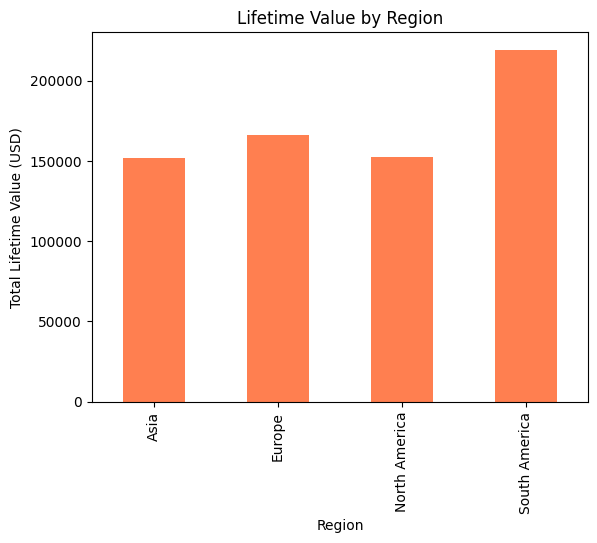

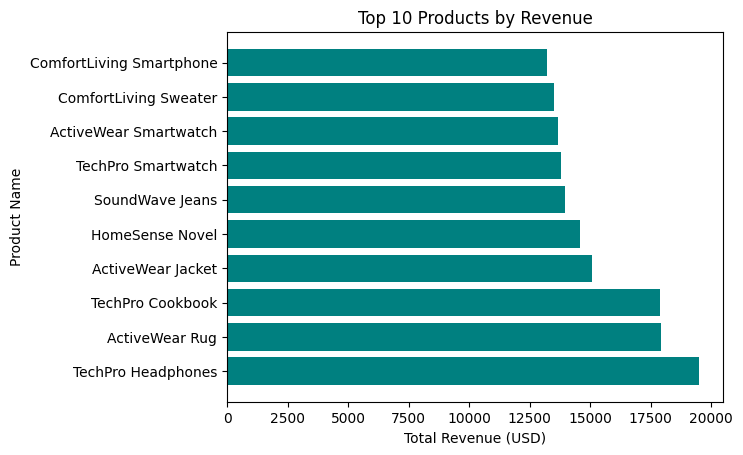

<ipython-input-5-eb904fc8b1ab>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=products, x='Category', y='Price', palette='pastel')


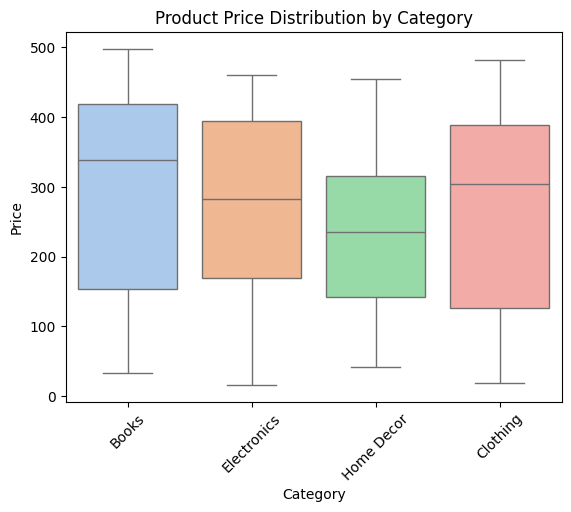

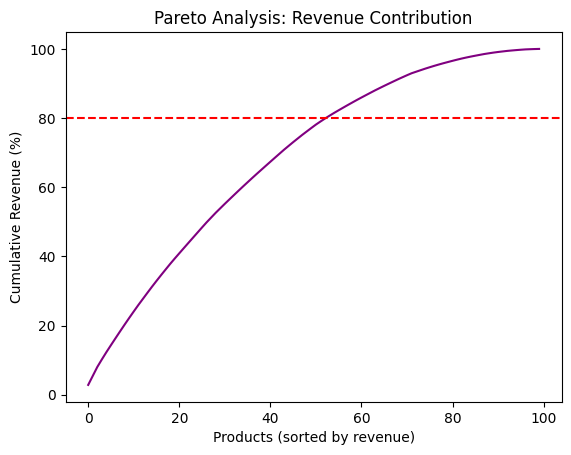

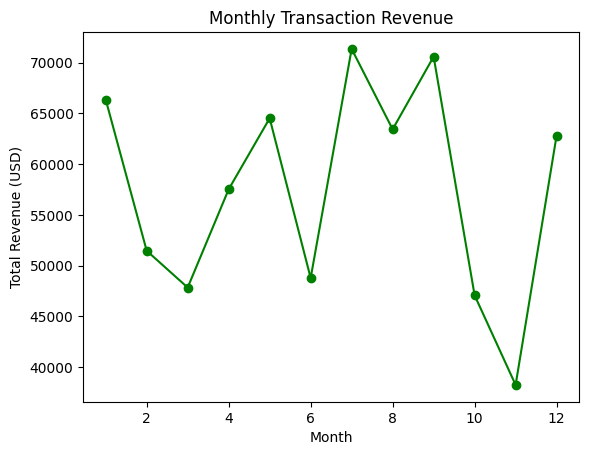

Number of repeat purchases: 25


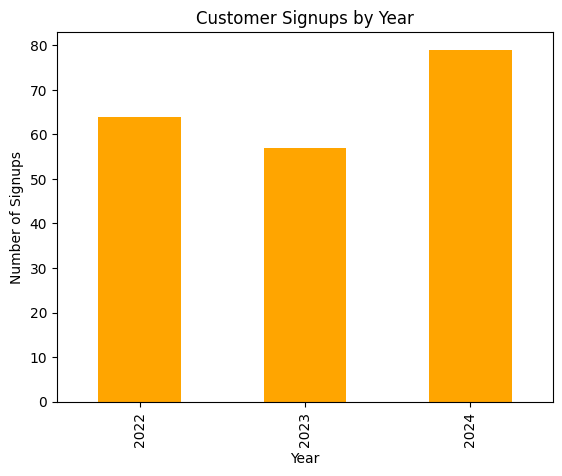

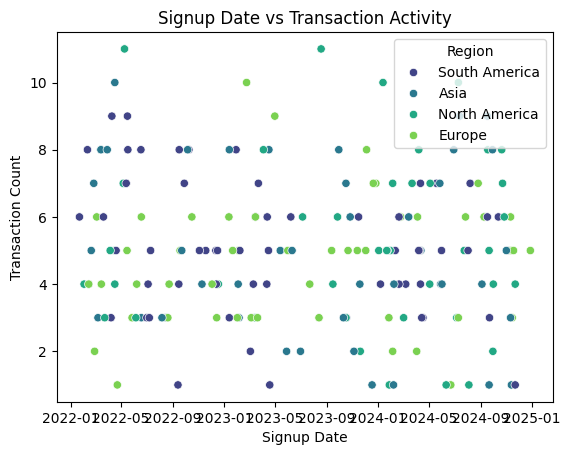

High-value customers contribute: 19.10580699968562 % of revenue.


In [5]:
# EDA: Customer Behavior Analysis
customer_transaction_counts = transactions['CustomerID'].value_counts()
plt.hist(customer_transaction_counts, bins=20, color='skyblue')
plt.title('Transaction Frequency per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

customer_ltv = transactions.groupby('CustomerID')['TotalValue'].sum()
ltv_by_region = customers.merge(customer_ltv, on='CustomerID').groupby('Region')['TotalValue'].sum()
ltv_by_region.plot(kind='bar', color='coral')
plt.title('Lifetime Value by Region')
plt.ylabel('Total Lifetime Value (USD)')
plt.xlabel('Region')
plt.show()

# EDA: Product Trends
top_products = transactions.groupby('ProductID')['TotalValue'].sum().nlargest(10)
top_products = top_products.reset_index().merge(products, on='ProductID')
plt.barh(top_products['ProductName'], top_products['TotalValue'], color='teal')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Product Name')
plt.show()

sns.boxplot(data=products, x='Category', y='Price', palette='pastel')
plt.title('Product Price Distribution by Category')
plt.xticks(rotation=45)
plt.show()

# Pareto Analysis
product_revenue = transactions.groupby('ProductID')['TotalValue'].sum()
cumulative_revenue = product_revenue.sort_values(ascending=False).cumsum()
cumulative_percentage = cumulative_revenue / cumulative_revenue.max() * 100
plt.plot(cumulative_percentage.values, color='purple')
plt.axhline(80, color='red', linestyle='--')
plt.title('Pareto Analysis: Revenue Contribution')
plt.xlabel('Products (sorted by revenue)')
plt.ylabel('Cumulative Revenue (%)')
plt.show()

# EDA: Transaction Patterns
transactions['Month'] = transactions['TransactionDate'].dt.month
txn_by_month = transactions.groupby('Month')['TotalValue'].sum()
txn_by_month.plot(kind='line', marker='o', color='green')
plt.title('Monthly Transaction Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue (USD)')
plt.show()

repeat_purchases = transactions.groupby(['CustomerID', 'ProductID']).size().reset_index(name='PurchaseCount')
repeat_purchases = repeat_purchases[repeat_purchases['PurchaseCount'] > 1]
print("Number of repeat purchases:", repeat_purchases.shape[0])

# EDA: Signup Trends
signup_counts = customers['SignupDate'].dt.year.value_counts().sort_index()
signup_counts.plot(kind='bar', color='orange')
plt.title('Customer Signups by Year')
plt.xlabel('Year')
plt.ylabel('Number of Signups')
plt.show()

# Correcting the merge operation by renaming the Series
txn_counts = transactions.groupby('CustomerID').size().reset_index(name='TransactionCount')
signup_vs_txn = customers.merge(txn_counts, on='CustomerID', how='left')

# Plotting
sns.scatterplot(data=signup_vs_txn, x='SignupDate', y='TransactionCount', hue='Region', palette='viridis')
plt.title('Signup Date vs Transaction Activity')
plt.xlabel('Signup Date')
plt.ylabel('Transaction Count')
plt.show()


# EDA: High-value Customers
high_value_customers = customer_ltv.nlargest(int(0.1 * len(customer_ltv)))
print("High-value customers contribute:", high_value_customers.sum() / customer_ltv.sum() * 100, "% of revenue.")